In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_test.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states for both input and reference texts
def extract_char(inputs, references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    extract_chars = []

    # Iterate through the batches of inputs and references
    for i in tqdm(range(0, len(inputs), batch_size), desc="Processing data batches"):
        # Prepare batch for input texts
        batch_inputs = inputs[i:i + batch_size]
        batch_references = references[i:i + batch_size]
        
        # Tokenize both input and reference texts
        inputs_combined = [f"{input_text} [SEP] {reference_text}" for input_text, reference_text in zip(batch_inputs, batch_references)]
        encoded_inputs = tokenizer(inputs_combined, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            # Get hidden states from the model
            outputs = model(**encoded_inputs)
        
        # Average the hidden states from the last layer for the combined input-reference representation
        combined_hidden_states = outputs.last_hidden_state.mean(dim=1)  # shape: (batch_size, hidden_size)
        extract_chars.append(combined_hidden_states.cpu().numpy())
    
    return np.vstack(extract_chars)

In [4]:
# Function to extract hidden states from the outputs of extract_char
def extract_hidden_states_combined(extract_chars, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    internal_states = []

    # Process the features in batches
    for i in tqdm(range(0, len(extract_chars), batch_size), desc="Processing internal states"):
        # Get the current batch of features
        batch_features = extract_chars[i:i + batch_size]

        # Check the shape and type of batch_features
        # print(f"Batch {i}: Shape: {batch_features.shape}, Type: {type(batch_features)}")

        # Ensure each feature is treated correctly for the tokenizer
        # Convert to list of strings (if necessary)
        batch_features = [str(feature.tolist()) for feature in batch_features]  # Convert each numpy array to string

        # Tokenize the string inputs
        inputs = tokenizer(batch_features, return_tensors="pt", padding=True, truncation=True).to(device)

        with torch.no_grad():
            # Get internal states from the model
            outputs = model(**inputs)

        # Average the internal states from the last layer
        internal_states.append(outputs.hidden_states[-1].mean(dim=1).cpu().numpy())

    return np.vstack(internal_states)


In [5]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[-1].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [6]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [7]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


In [9]:
# print("Extracting hidden states for non_infringement texts...")
# X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
# print("Extracting reference embeddings for non_infringement texts...")
# reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
# print("X_non_infringement:",X_non_infringement.shape)
# print("reference_embeddings_non_infringement:",reference_embeddings_non_infringement.shape)
# X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

# print("Extracting hidden states for infringement texts...")
# X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
# print("Extracting reference embeddings for infringement texts...")
# reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
# X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

print("Extracting characteristics for non_infringement texts/references")
X_non_infringement_char = extract_char(non_infringement_outputs, non_infringement_references, bert_model, bert_tokenizer)
print("Extracting hidden states for X_non_infringement_char")
X_non_infringement_combined = extract_hidden_states_combined(X_non_infringement_char, model, tokenizer)
# print("Extracting hidden states for internal states for non_infringement texts")
# X_non_infringement_input = extract_hidden_states(non_infringement_outputs, model, tokenizer)
# X_non_infringement_combined = np.hstack([X_non_infringement, X_non_infringement_input])

print("Extracting characteristics for infringement texts/references")
X_infringement_char = extract_char(infringement_outputs, infringement_references, bert_model, bert_tokenizer)
print("Extracting hidden states for X_infringement_char")
X_infringement_combined = extract_hidden_states_combined(X_infringement_char, model, tokenizer)
# print("Extracting hidden states for internal states for infringement texts")
# X_infringement_input = extract_hidden_states(infringement_outputs, model, tokenizer)
# X_infringement_combined = np.hstack([X_infringement, X_infringement_input])

Extracting characteristics for non_infringement texts/references


Processing data batches: 100%|██████████| 373/373 [00:05<00:00, 63.11it/s] 


Extracting hidden states for X_non_infringement_char


Processing internal states: 100%|██████████| 373/373 [10:55<00:00,  1.76s/it]


Extracting characteristics for infringement texts/references


Processing data batches: 100%|██████████| 354/354 [00:04<00:00, 74.77it/s] 


Extracting hidden states for X_infringement_char


Processing internal states: 100%|██████████| 354/354 [10:22<00:00,  1.76s/it]


In [10]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   1%|▏         | 7/500 [00:00<00:20, 24.05it/s]/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

Epoch 10/500, Loss: 1.2701
Test Accuracy at Epoch 10: 48.71%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.49      1.00      0.66       283
non_infringement       0.00      0.00      0.00       298

        accuracy                           0.49       581
       macro avg       0.24      0.50      0.33       581
    weighted avg       0.24      0.49      0.32       581

New best model saved with accuracy 48.71% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.49      1.00      0.66       283
non_infringement       0.00      0.00      0.00       298

        accuracy                           0.49       581
       macro avg       0.24      0.50      0.33       581
    weighted avg       0.24      0.49      0.32       581



Training Epochs:   3%|▎         | 17/500 [00:00<00:18, 25.80it/s]/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 20/500, Loss: 0.7061
Test Accuracy at Epoch 20: 48.71%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.49      1.00      0.66       283
non_infringement       0.00      0.00      0.00       298

        accuracy                           0.49       581
       macro avg       0.24      0.50      0.33       581
    weighted avg       0.24      0.49      0.32       581



Training Epochs:   6%|▌         | 28/500 [00:00<00:15, 31.05it/s]/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 30/500, Loss: 0.6944
Test Accuracy at Epoch 30: 51.29%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581

New best model saved with accuracy 51.29% at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581



Training Epochs:   9%|▉         | 44/500 [00:01<00:15, 29.47it/s]

Epoch 40/500, Loss: 0.6923
Test Accuracy at Epoch 40: 48.54%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.49      1.00      0.65       283
non_infringement       0.00      0.00      0.00       298

        accuracy                           0.49       581
       macro avg       0.24      0.50      0.33       581
    weighted avg       0.24      0.49      0.32       581



Training Epochs:  10%|▉         | 48/500 [00:01<00:14, 31.11it/s]/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 50/500, Loss: 0.6911
Test Accuracy at Epoch 50: 51.29%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581



Training Epochs:  12%|█▏        | 62/500 [00:02<00:17, 24.51it/s]

Epoch 60/500, Loss: 0.6901
Test Accuracy at Epoch 60: 55.25%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.87      0.10      0.17       283
non_infringement       0.53      0.99      0.69       298

        accuracy                           0.55       581
       macro avg       0.70      0.54      0.43       581
    weighted avg       0.70      0.55      0.44       581

New best model saved with accuracy 55.25% at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.87      0.10      0.17       283
non_infringement       0.53      0.99      0.69       298

        accuracy                           0.55       581
       macro avg       0.70      0.54      0.43       581
    weighted avg       0.70      0.55      0.44       581



Training Epochs:  15%|█▍        | 73/500 [00:02<00:17, 24.90it/s]

Epoch 70/500, Loss: 0.6889
Test Accuracy at Epoch 70: 58.52%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.68      0.28      0.40       283
non_infringement       0.56      0.87      0.68       298

        accuracy                           0.59       581
       macro avg       0.62      0.58      0.54       581
    weighted avg       0.62      0.59      0.54       581

New best model saved with accuracy 58.52% at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.68      0.28      0.40       283
non_infringement       0.56      0.87      0.68       298

        accuracy                           0.59       581
       macro avg       0.62      0.58      0.54       581
    weighted avg       0.62      0.59      0.54       581



Training Epochs:  17%|█▋        | 83/500 [00:03<00:16, 24.85it/s]

Epoch 80/500, Loss: 0.6874
Test Accuracy at Epoch 80: 62.48%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.69      0.41      0.52       283
non_infringement       0.60      0.83      0.69       298

        accuracy                           0.62       581
       macro avg       0.64      0.62      0.61       581
    weighted avg       0.64      0.62      0.61       581

New best model saved with accuracy 62.48% at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.69      0.41      0.52       283
non_infringement       0.60      0.83      0.69       298

        accuracy                           0.62       581
       macro avg       0.64      0.62      0.61       581
    weighted avg       0.64      0.62      0.61       581



Training Epochs:  19%|█▉        | 94/500 [00:03<00:14, 28.85it/s]

Epoch 90/500, Loss: 0.6855
Test Accuracy at Epoch 90: 62.48%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.69      0.41      0.52       283
non_infringement       0.60      0.83      0.69       298

        accuracy                           0.62       581
       macro avg       0.64      0.62      0.61       581
    weighted avg       0.64      0.62      0.61       581



Training Epochs:  21%|██        | 104/500 [00:03<00:13, 29.17it/s]

Epoch 100/500, Loss: 0.6835
Test Accuracy at Epoch 100: 63.17%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.69      0.44      0.54       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.63      0.62       581
    weighted avg       0.65      0.63      0.62       581

New best model saved with accuracy 63.17% at epoch 100
Best Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.69      0.44      0.54       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.63      0.62       581
    weighted avg       0.65      0.63      0.62       581



Training Epochs:  23%|██▎       | 114/500 [00:04<00:13, 29.41it/s]

Epoch 110/500, Loss: 0.6815
Test Accuracy at Epoch 110: 63.17%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.69      0.44      0.54       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.63      0.62       581
    weighted avg       0.65      0.63      0.62       581



Training Epochs:  25%|██▍       | 124/500 [00:04<00:12, 29.09it/s]

Epoch 120/500, Loss: 0.6797
Test Accuracy at Epoch 120: 62.48%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.69      0.42      0.52       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.62       581
       macro avg       0.64      0.62      0.61       581
    weighted avg       0.64      0.62      0.61       581



Training Epochs:  27%|██▋       | 135/500 [00:04<00:13, 27.68it/s]

Epoch 130/500, Loss: 0.6780
Test Accuracy at Epoch 130: 62.48%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.69      0.42      0.52       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.62       581
       macro avg       0.64      0.62      0.61       581
    weighted avg       0.64      0.62      0.61       581



Training Epochs:  29%|██▉       | 145/500 [00:05<00:13, 27.04it/s]

Epoch 140/500, Loss: 0.6764
Test Accuracy at Epoch 140: 62.65%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.69      0.42      0.52       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.62      0.61       581
    weighted avg       0.64      0.63      0.61       581



Training Epochs:  31%|███       | 156/500 [00:05<00:12, 28.34it/s]

Epoch 150/500, Loss: 0.6747
Test Accuracy at Epoch 150: 62.82%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.70      0.42      0.52       283
non_infringement       0.60      0.83      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.62      0.61       581
    weighted avg       0.65      0.63      0.61       581



Training Epochs:  33%|███▎      | 164/500 [00:06<00:12, 27.27it/s]

Epoch 160/500, Loss: 0.6729
Test Accuracy at Epoch 160: 63.17%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.70      0.42      0.53       283
non_infringement       0.60      0.83      0.70       298

        accuracy                           0.63       581
       macro avg       0.65      0.63      0.61       581
    weighted avg       0.65      0.63      0.61       581



Training Epochs:  34%|███▍      | 171/500 [00:06<00:12, 25.83it/s]

Epoch 170/500, Loss: 0.6709
Test Accuracy at Epoch 170: 62.65%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.69      0.42      0.52       283
non_infringement       0.60      0.83      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.62      0.61       581
    weighted avg       0.65      0.63      0.61       581



Training Epochs:  36%|███▋      | 182/500 [00:06<00:14, 21.85it/s]

Epoch 180/500, Loss: 0.6688
Test Accuracy at Epoch 180: 61.79%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.67      0.43      0.52       283
non_infringement       0.59      0.80      0.68       298

        accuracy                           0.62       581
       macro avg       0.63      0.61      0.60       581
    weighted avg       0.63      0.62      0.60       581



Training Epochs:  38%|███▊      | 192/500 [00:07<00:13, 23.33it/s]

Epoch 190/500, Loss: 0.6665
Test Accuracy at Epoch 190: 62.31%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.67      0.45      0.54       283
non_infringement       0.60      0.79      0.68       298

        accuracy                           0.62       581
       macro avg       0.63      0.62      0.61       581
    weighted avg       0.63      0.62      0.61       581



Training Epochs:  41%|████      | 204/500 [00:07<00:10, 27.38it/s]

Epoch 200/500, Loss: 0.6639
Test Accuracy at Epoch 200: 61.62%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.65      0.45      0.53       283
non_infringement       0.60      0.78      0.67       298

        accuracy                           0.62       581
       macro avg       0.63      0.61      0.60       581
    weighted avg       0.63      0.62      0.61       581



Training Epochs:  42%|████▏     | 211/500 [00:07<00:11, 25.12it/s]

Epoch 210/500, Loss: 0.6609
Test Accuracy at Epoch 210: 62.13%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.66      0.47      0.55       283
non_infringement       0.60      0.77      0.67       298

        accuracy                           0.62       581
       macro avg       0.63      0.62      0.61       581
    weighted avg       0.63      0.62      0.61       581



Training Epochs:  45%|████▍     | 224/500 [00:08<00:10, 26.46it/s]

Epoch 220/500, Loss: 0.6576
Test Accuracy at Epoch 220: 61.79%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.65      0.47      0.55       283
non_infringement       0.60      0.76      0.67       298

        accuracy                           0.62       581
       macro avg       0.62      0.61      0.61       581
    weighted avg       0.62      0.62      0.61       581



Training Epochs:  47%|████▋     | 234/500 [00:08<00:09, 27.11it/s]

Epoch 230/500, Loss: 0.6539
Test Accuracy at Epoch 230: 62.65%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.65      0.51      0.57       283
non_infringement       0.61      0.74      0.67       298

        accuracy                           0.63       581
       macro avg       0.63      0.62      0.62       581
    weighted avg       0.63      0.63      0.62       581



Training Epochs:  48%|████▊     | 238/500 [00:08<00:08, 29.43it/s]/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 240/500, Loss: 0.7547
Test Accuracy at Epoch 240: 51.29%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581



Training Epochs:  51%|█████     | 256/500 [00:09<00:08, 30.48it/s]

Epoch 250/500, Loss: 0.6885
Test Accuracy at Epoch 250: 51.81%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       1.00      0.01      0.02       283
non_infringement       0.52      1.00      0.68       298

        accuracy                           0.52       581
       macro avg       0.76      0.51      0.35       581
    weighted avg       0.75      0.52      0.36       581



Training Epochs:  53%|█████▎    | 264/500 [00:09<00:08, 28.42it/s]

Epoch 260/500, Loss: 0.6879
Test Accuracy at Epoch 260: 62.99%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.70      0.41      0.52       283
non_infringement       0.60      0.84      0.70       298

        accuracy                           0.63       581
       macro avg       0.65      0.62      0.61       581
    weighted avg       0.65      0.63      0.61       581



Training Epochs:  55%|█████▌    | 275/500 [00:10<00:08, 27.15it/s]

Epoch 270/500, Loss: 0.6859
Test Accuracy at Epoch 270: 55.94%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.68      0.18      0.28       283
non_infringement       0.54      0.92      0.68       298

        accuracy                           0.56       581
       macro avg       0.61      0.55      0.48       581
    weighted avg       0.61      0.56      0.49       581



Training Epochs:  56%|█████▋    | 282/500 [00:10<00:07, 28.76it/s]

Epoch 280/500, Loss: 0.6829
Test Accuracy at Epoch 280: 62.82%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.69      0.42      0.53       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.62      0.61       581
    weighted avg       0.65      0.63      0.61       581



Training Epochs:  59%|█████▊    | 293/500 [00:10<00:07, 26.95it/s]

Epoch 290/500, Loss: 0.6803
Test Accuracy at Epoch 290: 62.65%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.69      0.42      0.53       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.63       581
       macro avg       0.64      0.62      0.61       581
    weighted avg       0.64      0.63      0.61       581



Training Epochs:  61%|██████▏   | 307/500 [00:11<00:06, 31.66it/s]

Epoch 300/500, Loss: 0.6779
Test Accuracy at Epoch 300: 62.82%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.69      0.42      0.53       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.62      0.61       581
    weighted avg       0.65      0.63      0.61       581



Training Epochs:  62%|██████▏   | 311/500 [00:11<00:05, 33.09it/s]

Epoch 310/500, Loss: 0.6757
Test Accuracy at Epoch 310: 62.99%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.70      0.42      0.53       283
non_infringement       0.60      0.83      0.70       298

        accuracy                           0.63       581
       macro avg       0.65      0.62      0.61       581
    weighted avg       0.65      0.63      0.61       581



Training Epochs:  65%|██████▌   | 325/500 [00:11<00:05, 31.57it/s]

Epoch 320/500, Loss: 0.6737
Test Accuracy at Epoch 320: 62.99%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.70      0.42      0.53       283
non_infringement       0.60      0.83      0.70       298

        accuracy                           0.63       581
       macro avg       0.65      0.62      0.61       581
    weighted avg       0.65      0.63      0.61       581



Training Epochs:  67%|██████▋   | 333/500 [00:12<00:05, 31.68it/s]

Epoch 330/500, Loss: 0.6721
Test Accuracy at Epoch 330: 63.34%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.71      0.42      0.53       283
non_infringement       0.60      0.83      0.70       298

        accuracy                           0.63       581
       macro avg       0.65      0.63      0.61       581
    weighted avg       0.65      0.63      0.62       581

New best model saved with accuracy 63.34% at epoch 330
Best Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.71      0.42      0.53       283
non_infringement       0.60      0.83      0.70       298

        accuracy                           0.63       581
       macro avg       0.65      0.63      0.61       581
    weighted avg       0.65      0.63      0.62       581



Training Epochs:  69%|██████▉   | 347/500 [00:12<00:04, 34.28it/s]

Epoch 340/500, Loss: 0.6706
Test Accuracy at Epoch 340: 63.17%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.71      0.42      0.52       283
non_infringement       0.60      0.84      0.70       298

        accuracy                           0.63       581
       macro avg       0.65      0.63      0.61       581
    weighted avg       0.65      0.63      0.61       581



Training Epochs:  71%|███████   | 355/500 [00:12<00:04, 31.95it/s]

Epoch 350/500, Loss: 0.6692
Test Accuracy at Epoch 350: 62.65%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.69      0.42      0.52       283
non_infringement       0.60      0.83      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.62      0.61       581
    weighted avg       0.65      0.63      0.61       581



Training Epochs:  73%|███████▎  | 365/500 [00:13<00:03, 35.74it/s]

Epoch 360/500, Loss: 0.6678
Test Accuracy at Epoch 360: 62.13%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.68      0.41      0.52       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.62       581
       macro avg       0.64      0.62      0.60       581
    weighted avg       0.64      0.62      0.60       581



Training Epochs:  75%|███████▍  | 373/500 [00:13<00:03, 33.98it/s]

Epoch 370/500, Loss: 0.6662
Test Accuracy at Epoch 370: 60.76%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.67      0.39      0.49       283
non_infringement       0.58      0.82      0.68       298

        accuracy                           0.61       581
       macro avg       0.63      0.60      0.59       581
    weighted avg       0.62      0.61      0.59       581



Training Epochs:  77%|███████▋  | 387/500 [00:13<00:03, 34.39it/s]

Epoch 380/500, Loss: 0.6645
Test Accuracy at Epoch 380: 61.96%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.66      0.45      0.53       283
non_infringement       0.60      0.79      0.68       298

        accuracy                           0.62       581
       macro avg       0.63      0.62      0.61       581
    weighted avg       0.63      0.62      0.61       581



Training Epochs:  78%|███████▊  | 391/500 [00:13<00:03, 34.60it/s]

Epoch 390/500, Loss: 0.6627
Test Accuracy at Epoch 390: 61.62%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.66      0.45      0.53       283
non_infringement       0.60      0.78      0.68       298

        accuracy                           0.62       581
       macro avg       0.63      0.61      0.60       581
    weighted avg       0.63      0.62      0.60       581



Training Epochs:  81%|████████  | 404/500 [00:14<00:02, 34.19it/s]

Epoch 400/500, Loss: 0.6606
Test Accuracy at Epoch 400: 61.27%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.65      0.45      0.53       283
non_infringement       0.59      0.77      0.67       298

        accuracy                           0.61       581
       macro avg       0.62      0.61      0.60       581
    weighted avg       0.62      0.61      0.60       581



Training Epochs:  83%|████████▎ | 416/500 [00:14<00:02, 34.82it/s]

Epoch 410/500, Loss: 0.6581
Test Accuracy at Epoch 410: 60.76%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.64      0.45      0.53       283
non_infringement       0.59      0.76      0.66       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581



Training Epochs:  85%|████████▍ | 424/500 [00:14<00:02, 33.57it/s]

Epoch 420/500, Loss: 0.6552
Test Accuracy at Epoch 420: 60.93%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.64      0.46      0.53       283
non_infringement       0.59      0.75      0.66       298

        accuracy                           0.61       581
       macro avg       0.62      0.61      0.60       581
    weighted avg       0.62      0.61      0.60       581



Training Epochs:  87%|████████▋ | 433/500 [00:15<00:02, 30.79it/s]

Epoch 430/500, Loss: 0.6518
Test Accuracy at Epoch 430: 61.96%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.64      0.49      0.56       283
non_infringement       0.61      0.74      0.67       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.61       581
    weighted avg       0.62      0.62      0.61       581



Training Epochs:  88%|████████▊ | 442/500 [00:15<00:01, 33.82it/s]

Epoch 440/500, Loss: 0.6822
Test Accuracy at Epoch 440: 38.04%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.31      0.23      0.26       283
non_infringement       0.42      0.53      0.47       298

        accuracy                           0.38       581
       macro avg       0.36      0.38      0.36       581
    weighted avg       0.37      0.38      0.37       581



Training Epochs:  91%|█████████ | 455/500 [00:15<00:01, 35.01it/s]

Epoch 450/500, Loss: 0.6817
Test Accuracy at Epoch 450: 61.62%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.70      0.37      0.49       283
non_infringement       0.59      0.85      0.69       298

        accuracy                           0.62       581
       macro avg       0.64      0.61      0.59       581
    weighted avg       0.64      0.62      0.59       581



Training Epochs:  93%|█████████▎| 463/500 [00:15<00:01, 32.06it/s]

Epoch 460/500, Loss: 0.6843
Test Accuracy at Epoch 460: 54.22%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.52      0.91      0.66       283
non_infringement       0.70      0.19      0.30       298

        accuracy                           0.54       581
       macro avg       0.61      0.55      0.48       581
    weighted avg       0.61      0.54      0.48       581



Training Epochs:  94%|█████████▍| 472/500 [00:16<00:00, 34.33it/s]

Epoch 470/500, Loss: 0.6778
Test Accuracy at Epoch 470: 62.48%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.66      0.47      0.55       283
non_infringement       0.60      0.78      0.68       298

        accuracy                           0.62       581
       macro avg       0.63      0.62      0.61       581
    weighted avg       0.63      0.62      0.62       581



Training Epochs:  97%|█████████▋| 484/500 [00:16<00:00, 33.97it/s]

Epoch 480/500, Loss: 0.6747
Test Accuracy at Epoch 480: 62.99%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.69      0.43      0.53       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.62      0.61       581
    weighted avg       0.65      0.63      0.61       581



Training Epochs:  99%|█████████▉| 497/500 [00:16<00:00, 35.40it/s]

Epoch 490/500, Loss: 0.6716
Test Accuracy at Epoch 490: 63.34%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.69      0.45      0.54       283
non_infringement       0.61      0.81      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.63      0.62       581
    weighted avg       0.65      0.63      0.62       581



Training Epochs: 100%|██████████| 500/500 [00:17<00:00, 29.23it/s]
/tmp/ipykernel_1849570/1033092828.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.6692
Test Accuracy at Epoch 500: 62.99%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.68      0.45      0.54       283
non_infringement       0.61      0.80      0.69       298

        accuracy                           0.63       581
       macro avg       0.64      0.63      0.62       581
    weighted avg       0.64      0.63      0.62       581



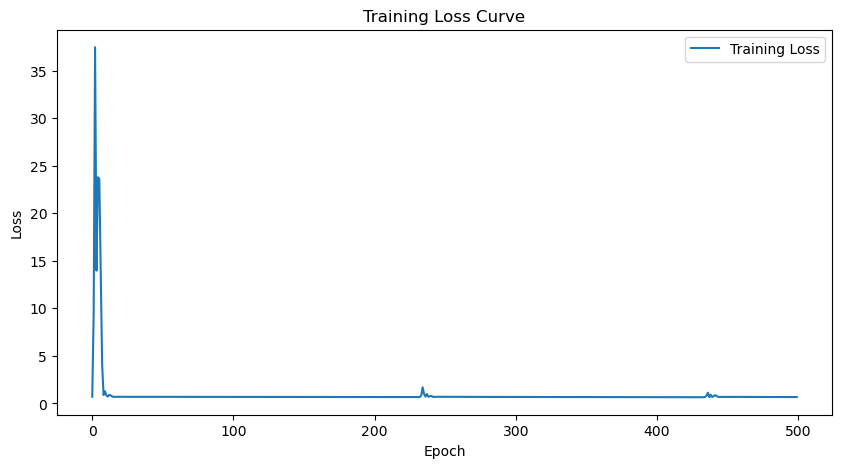

Final Model Accuracy: 63.34%


In [11]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [12]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_test.pth'.


In [13]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.71      0.42      0.53       283
non_infringement       0.60      0.83      0.70       298

        accuracy                           0.63       581
       macro avg       0.65      0.63      0.61       581
    weighted avg       0.65      0.63      0.62       581



/tmp/ipykernel_1849570/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 